# Variational Quantum Singular Value Decomposition

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In this tutorial, we will go through the concept of classical singular value decomposition (SVD) and the quantum neural network (QNN) version of variational quantum singular value decomposition (VQSVD) [1]. The tutorial consists of the following two parts: 
- Decompose a randomly generated $8\times8$ complex matrix; 
- Apply SVD on image compression.

## Background

Singular value decomposition (SVD) has many applications, including principal component analysis (PCA), solving linear equations and recommender systems. The main task is formulated as following:
> Given a complex matrix $M \in \mathbb{C}^{m \times n}$, find the decomposition in form $M = UDV^\dagger$, where $U_{m\times m}$ and $V^\dagger_{n\times n}$ are unitary matrices, which satisfy the property $UU^\dagger = VV^\dagger = I$.

- The column vectors $|u_j\rangle$ of the unitary matrix $U$ are called left singular vectors $\{|u_j\rangle\}_{j=1}^{m}$ form an orthonormal basis. These column vectors are the eigenvectors of the matrix $MM^\dagger$.
- Similarly, the column vectors $\{|v_j\rangle\}_{j=1}^{n}$ of the unitary matrix $V$ are the eigenvectors of $M^\dagger M$ and form an orthonormal basis.
- The diagonal elements of the matrix $D_{m\times n}$ are singular values $d_j$ arranged in a descending order.

For the convenience, we assume that the $M$ appearing below are all square matrices. Let's first look at an example: 

$$
M = 2*X\otimes Z + 6*Z\otimes X + 3*I\otimes I = 
\begin{bmatrix} 
3 &6 &2 &0 \\
6 &3 &0 &-2 \\
2 &0 &3 &-6 \\
0 &-2 &-6 &3 
\end{bmatrix}, \tag{1}
$$

Then the singular value decomposition of the matrix can be expressed as:

$$
M = UDV^\dagger = 
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &1 &1 \\
-1 &-1 &-1 &-1 \\
-1 &1 &-1 &1 \\
1 &-1 &-1 &1 
\end{bmatrix}
\begin{bmatrix} 
11 &0 &0 &0 \\
0 &7 &0 &0 \\
0 &0 &5 &0 \\
0 &0 &0 &1 
\end{bmatrix}
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &-1 &-1 \\
-1 &-1 &1 &1 \\
-1 &1 &1 &-1 \\
1 &-1 &1 &-1 
\end{bmatrix}. \tag{2}
$$

Import packages.

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
from scipy.stats import unitary_group
from scipy.linalg import norm

import paddle.fluid as fluid
from paddle.complex import matmul, transpose, trace
from paddle_quantum.circuit import *
from paddle_quantum.utils import *



# Draw the learning curve in the optimization process
def loss_plot(loss):
    '''
    loss is a list, this function plots loss over iteration
    '''
    plt.plot(list(range(1, len(loss)+1)), loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss Over Iteration')
    plt.show()

## Classical Singular Value Decomposition

With the above mathematical definition, one can realize SVD numerically through NumPy.

In [2]:
# Generate matrix M
def M_generator():
    I = np.array([[1, 0], [0, 1]])
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    M = 2 *np.kron(X, Z) + 6 * np.kron(Z, X) + 3 * np.kron(I, I)
    return M.astype('complex64')

print('The matrix M we want to decompose is: ')
print(M_generator())

The matrix M we want to decompose is: 
[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


In [3]:
# We only need the following line of code to complete SVD
U, D, V_dagger = np.linalg.svd(M_generator(), full_matrices=True)


# Print decomposition results
print("The singular values of the matrix from large to small are:")
print(D)
print("The decomposed unitary matrix U is:")
print(U)
print("The decomposed unitary matrix V_dagger is:")
print(V_dagger)

The singular values of the matrix from large to small are:
[11.  7.  5.  1.]
The decomposed unitary matrix U is:
[[-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]
The decomposed unitary matrix V_dagger is:
[[-0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]]


In [4]:
# Then assemble it back, can we restore the original matrix?
M_reconst = np.matmul(U, np.matmul(np.diag(D), V_dagger))
print(M_reconst)

[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


Surely, we can be restored the original matrix $M$! One can further modify the matrix, see what happens if it is not a square matrix.

---

## Quantum Singular Value Decomposition

Next, let's take a look at what the quantum version of singular value decomposition is all about. In summary, we transform the problem of matrix factorization into an optimization problem with the variational principle of singular values. Specifically, this is achieved through the following four steps:

- Prepare an orthonormal basis $\{|\psi_j\rangle\}$, one can take the computational basis $\{ |000\rangle, |001\rangle,\cdots |111\rangle\}$ (this is in the case of 3 qubits)
- Prepare two parameterized quantum neural networks $U(\theta)$ and $V(\phi)$ to learn left/right singular vectors respectively
- Use quantum neural network to estimate singular values $m_j = \text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$
- Design the loss function $\mathcal{L}(\theta)$ and use PaddlePaddle Deep Learning framework to maximize the following quantity, 

$$
L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle\psi_j|U(\theta)^{\dagger} MV(\phi)|\psi_j\rangle. \tag{3}
$$

Where $q_1>\cdots>q_T>0$ is the adjustable weights (hyperparameter), and $T$ represents the rank we want to learn or the total number of singular values to be learned.



### Case 1: Decompose a randomly generated $8\times8$ complex matrix

Then we look at a specific example, which can better explain the overall process.

#### Define matrix $M$

In [5]:
# First fix the random seed, in order to reproduce the results at any time
np.random.seed(42)

# Set the number of qubits, which determines the dimension of the Hilbert space
N = 3

# Make a random matrix generator
def random_M_generator():
    M = np.random.randint(10, size = (2**N, 2**N)) + 1j*np.random.randint(10, size = (2**N, 2**N))
    return M

M = random_M_generator()
M_err = np.copy(M)


# Output the matrix M
print('The matrix M we want to decompose is:')
print(M)

# Apply SVD and record the exact singular values
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
print("The singular values of the matrix M are:")
print(D)

The matrix M we want to decompose is:
[[6.+1.j 3.+9.j 7.+3.j 4.+7.j 6.+6.j 9.+8.j 2.+7.j 6.+4.j]
 [7.+1.j 4.+4.j 3.+7.j 7.+9.j 7.+8.j 2.+8.j 5.+0.j 4.+8.j]
 [1.+6.j 7.+8.j 5.+7.j 1.+0.j 4.+7.j 0.+7.j 9.+2.j 5.+0.j]
 [8.+7.j 0.+2.j 9.+2.j 2.+0.j 6.+4.j 3.+9.j 8.+6.j 2.+9.j]
 [4.+8.j 2.+6.j 6.+8.j 4.+7.j 8.+1.j 6.+0.j 1.+6.j 3.+6.j]
 [8.+7.j 1.+4.j 9.+2.j 8.+7.j 9.+5.j 4.+2.j 1.+0.j 3.+2.j]
 [6.+4.j 7.+2.j 2.+0.j 0.+4.j 3.+9.j 1.+6.j 7.+6.j 3.+8.j]
 [1.+9.j 5.+9.j 5.+2.j 9.+6.j 3.+0.j 5.+3.j 1.+3.j 9.+4.j]]
The singular values of the matrix M are:
[54.83484985 19.18141073 14.98866247 11.61419557 10.15927045  7.60223249
  5.81040539  3.30116001]


#### Hyper-parameters

In [6]:
# Hyperparameter settings
N = 3       # Number of qubits
T = 8       # Set the number of rank you want to learn
ITR = 100   # Number of iterations
LR = 0.02   # Learning rate
SEED = 14   # Random seed

# Set the learning weight 
weight = np.arange(3 * T, 0, -3).astype('complex128')
print('The selected weight is:')
print(weight)

The selected weight is:
[24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]


#### Building a quantum neural network

We design QNN with the following structure:

In [7]:
# Set circuit parameters
cir_depth = 40              # circuit depth
block_len = 2               # length of each block
theta_size = N * block_len * cir_depth  # size of the network parameter theta


# Define quantum neural network
def U_theta(theta):

    # Initialize the network with UAnsatz
    cir = UAnsatz(N)
    
    # Build QNN
    for layer_num in range(cir_depth):
        
        for which_qubit in range(N):
            cir.ry(theta[block_len * layer_num * N + which_qubit], which_qubit)
        
        for which_qubit in range(N):
            cir.rz(theta[(block_len * layer_num + 1) * N + which_qubit], which_qubit)

        for which_qubit in range(1, N):
            cir.cnot([which_qubit - 1, which_qubit])
        cir.cnot([N - 1, 0])

    return cir.U

#### Training model and loss function
Then we complete the main part of the algorithm:

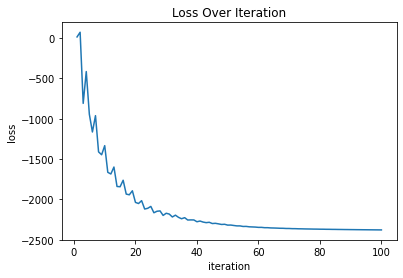

In [8]:
class NET(fluid.dygraph.Layer):
    
    # Initialize the list of learnable parameters, and fill the initial value with the uniform distribution of [0, 2*pi]
    def __init__(self, shape, param_attr=fluid.initializer.Uniform(
        low=0.0, high=2 * np.pi), dtype='float64'):
        super(NET, self).__init__()
        
        # Create the parameter theta for learning U
        self.theta = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype,is_bias=False)
        
        # Create a parameter phi to learn V_dagger
        self.phi = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
        # Convert Numpy array to variable supported in Paddle dynamic graph mode
        self.M = fluid.dygraph.to_variable(M)
        self.weight = fluid.dygraph.to_variable(weight)

    # Define loss function and forward propagation mechanism
    def forward(self):
        
        # Get the unitary matrix representation of the quantum neural network
        U = U_theta(self.theta)
        U_dagger = dagger(U)
        
        
        V = U_theta(self.phi)
        V_dagger = dagger(V)
        
        # Initialize the loss function and singular value memory
        loss = 0
        singular_values = np.zeros(T)
        
        # Define loss function
        for i in range(T):
            loss -= self.weight.real[i] * matmul(U_dagger,matmul(self.M, V)).real[i][i]
            singular_values[i] = (matmul(U_dagger, matmul(self.M, V)).real[i][i]).numpy()
        
        # Function returns two matrices U and V_dagger, learned singular values and loss function
        return U, V_dagger, loss, singular_values
    
# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []

# Start Paddle dynamic graph mode
with fluid.dygraph.guard():
  
    # Determine the parameter dimension of the network
    net = NET([theta_size])
    
    # We use Adam optimizer for better performance
    # One can change it to SGD or RMSprop.
    opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())
    
    # Optimization cycle
    for itr in range(ITR):
        
        # Forward propagation to calculate loss function
        U, V_dagger, loss, singular_values = net()
        
        # Under the dynamic graph mode, back propagation minimizes the loss function
        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()

        # Record optimization intermediate results
        loss_list.append(loss[0][0].numpy())
        singular_value_list.append(singular_values)

    # Record the last two learned unitary matrices
    U_learned = U.real.numpy() + 1j * U.imag.numpy()
    V_dagger_learned = V_dagger.real.numpy() + 1j * V_dagger.imag.numpy()

# Draw a learning curve
loss_plot(loss_list)

#### Error analysis

We will explore the accuracy of the quantum version of singular value decomposition. In the above section, we mentioned that the original matrix can be expressed with less information obtained by decomposition. Specifically, it uses the first $T$ singular values ​​and the first $T$ left and right singular vectors to reconstruct a matrix:

$$
M_{re}^{(T)} = UDV^{\dagger}, \tag{4}
$$

For matrix $M$ with rank $r$, the error will decreasing dramatically as more and more singular values are used to reconstruct it. The classic singular value algorithm can guarantee:

$$
\lim_{T\rightarrow r} ||M-M_{re}^{(T)}||^2_2 = 0, \tag{5}
$$

The distance measurement between the matrices is calculated by the Frobenius-norm,

$$
||M||_2 = \sqrt{\sum_{i,j} |M_{ij}|^2}. \tag{6}
$$

The current quantum version of singular value decomposition still needs a lot of efforts to be optimized. In theory, it can only guarantee the reduction of accumulated errors.

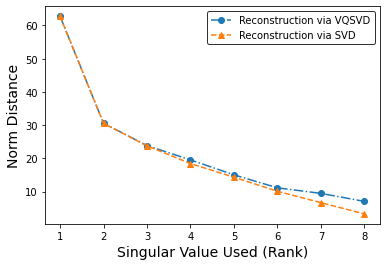

In [12]:
singular_value = singular_value_list[-1]
err_subfull, err_local, err_SVD = [], [], []
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)


# Calculate the Frobenius-norm error
for i in range(T):
    lowrank_mat = np.matrix(U[:, :i]) * np.diag(D[:i])* np.matrix(V_dagger[:i, :])
    recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_value[:i])* np.matrix(V_dagger_learned[:i, :])
    err_local.append(norm(lowrank_mat - recons_mat)) 
    err_subfull.append(norm(M_err - recons_mat))
    err_SVD.append(norm(M_err- lowrank_mat))


# Plot
fig, ax = plt.subplots()
ax.plot(list(range(1, T+1)), err_subfull, "o-.", 
        label = 'Reconstruction via VQSVD')
ax.plot(list(range(1, T+1)), err_SVD, "^--", 
        label='Reconstruction via SVD')
plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
plt.ylabel('Norm Distance', fontsize = 14)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('k')
# plt.savefig("vqsvd-fig-error.png", bbox_inches='tight', dpi=600)

---
### Case 2: Image compression

In order to fulfill image processing tasks, we first import the necessary package.



In [13]:
# Image processing package PIL
from PIL import Image

# Open the picture prepared in advance
img = Image.open('./figures/MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)/255

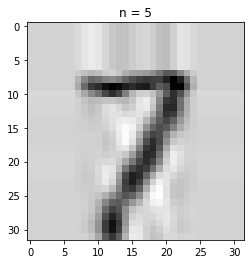

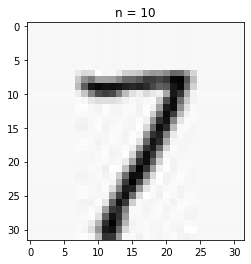

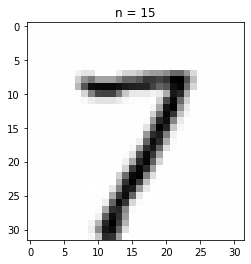

In [14]:
# Then we look at the effect of the classic singular value decomposition
U, sigma, V = np.linalg.svd(imgmat)

for i in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

In [15]:
# Hyper-parameters
N = 5           # Number of qubits
T = 8           # Set the number of rank you want to learn
ITR = 200       # Number of iterations
LR = 0.02       # Learning rate
SEED = 14       # Random number seed

# Set the learning weight
weight = np.arange(2 * T, 0, -2).astype('complex128')

# Convert the image into numpy array
def Mat_generator():
    imgmat = np.array(list(img.getdata(band=0)), float)
    imgmat.shape = (img.size[1], img.size[0])
    lenna = np.matrix(imgmat)
    return lenna.astype('complex128')

M_err = Mat_generator()
U, D, V_dagger = np.linalg.svd(Mat_generator(), full_matrices=True)

# Set circuit parameters
cir_depth = 40 # Circuit depth
block_len = 1 # The length of each module
theta_size = N * block_len * cir_depth # The size of the network parameter theta

In [16]:
# Define quantum neural network
def U_theta(theta):

    # Initialize the network with UAnsatz
    cir = UAnsatz(N)
    
    # Build a hierarchy:
    for layer_num in range(cir_depth):
        
        for which_qubit in range(N):
            cir.ry(theta[block_len * layer_num * N + which_qubit], which_qubit)

        for which_qubit in range(1, N):
            cir.cnot([which_qubit - 1, which_qubit])

    return cir.U

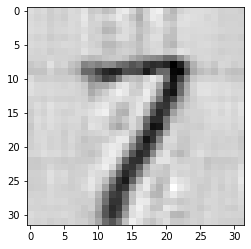

In [18]:
class NET(fluid.dygraph.Layer):
    
    # Initialize the list of learnable parameters, and fill the initial value with the uniform distribution of [0, 2*pi]
    def __init__(self, shape, param_attr=fluid.initializer.Uniform(
        low=0.0, high=2 * np.pi), dtype='float64'):
        super(NET, self).__init__()
        
        # Create the parameter theta for learning U
        self.theta = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
        # Create a parameter phi to learn V_dagger
        self.phi = self.create_parameter(shape=shape, attr=param_attr, dtype=dtype, is_bias=False)
        
        # Convert Numpy array to variable supported in Paddle dynamic graph mode
        self.M = fluid.dygraph.to_variable(Mat_generator())
        self.weight = fluid.dygraph.to_variable(weight)

    # Define loss function and forward propagation mechanism
    def forward(self):
        
        # Get the unitary matrix representation of the quantum neural network
        U = U_theta(self.theta)
        U_dagger = dagger(U)
        
        
        V = U_theta(self.phi)
        V_dagger = dagger(V)
        
        # Initialize the loss function and singular value memory
        loss = 0
        singular_values = np.zeros(T)
        
        # Define loss function
        for i in range(T):
            loss -= self.weight.real[i]* matmul(U_dagger, matmul(self.M, V)).real[i][i]
            singular_values[i] = (matmul(U_dagger, matmul(self.M, V)).real[i][i]).numpy()
        
        # Function returns two matrices U and V_dagger, learned singular values and loss function
        return U, V_dagger, loss, singular_values

# Record the optimization process
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []


# Start Paddle dynamic graph mode
with fluid.dygraph.guard():
    
    net = NET([theta_size])
    
    # We use Adam optimizer for better performance
    # One can change it to SGD or RMSprop.
    opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())
    
    # Optimization loop
    for itr in range(ITR):
        
        # Forward propagation to calculate loss function
        U, V_dagger, loss, singular_values = net()
        
        # Under the dynamic graph mode, back propagation minimizes the loss function
        loss.backward()
        opt.minimize(loss)
        net.clear_gradients()

        # Record optimization intermediate results
        loss_list.append(loss[0][0].numpy())
        singular_value_list.append(singular_values)

    # Record the last two unitary matrices learned
    U_learned = U.real.numpy() + 1j * U.imag.numpy()
    V_dagger_learned = V_dagger.real.numpy() + 1j*V_dagger.imag.numpy()

singular_value = singular_value_list[-1]
mat = np.matrix(U_learned.real[:, :T]) * np.diag(singular_value[:T])* np.matrix(V_dagger_learned.real[:T, :])

reconstimg = mat
plt.imshow(reconstimg, cmap='gray')

_______


## References:

[1] Wang, X., Song, Z. & Wang, Y. Variational Quantum Singular Value Decomposition. [arXiv:2006.02336 (2020).](https://arxiv.org/abs/2006.02336)

